In [28]:
import pandas as pd
import numpy as np
from collections import Counter
import keras 
import matplotlib.pyplot as plt
import string
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
import gdown
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import random
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
gdown.download('https://drive.google.com/uc?id=163BlB6eSlnFMuh3j3xkGgw0SbuGiyCwf', 'spam.csv', quiet=True)
df = pd.read_csv('spam.csv', encoding='latin-1', names=["Spam", "SMS", "n1", "n2", "n3"])
df = df.drop(axis=1, columns=['n1', 'n2', 'n3'])
df = df.drop(axis=0, index=[0])
print(df.head(n=10))
print(f"\n Размеры датасета: {df.shape}")

    Spam                                                SMS
1    ham  Go until jurong point, crazy.. Available only ...
2    ham                      Ok lar... Joking wif u oni...
3   spam  Free entry in 2 a wkly comp to win FA Cup fina...
4    ham  U dun say so early hor... U c already then say...
5    ham  Nah I don't think he goes to usf, he lives aro...
6   spam  FreeMsg Hey there darling it's been 3 week's n...
7    ham  Even my brother is not like to speak with me. ...
8    ham  As per your request 'Melle Melle (Oru Minnamin...
9   spam  WINNER!! As a valued network customer you have...
10  spam  Had your mobile 11 months or more? U R entitle...

 Размеры датасета: (5572, 2)


Мы используем датасет с SMS ками. Провизуализируем характеристики датасета

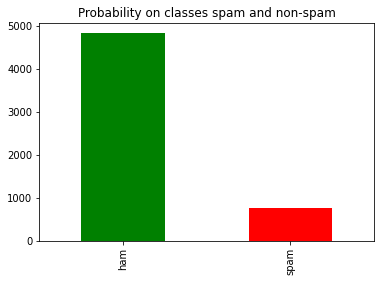

In [15]:
count_Class=pd.value_counts(df["Spam"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Probability on classes spam and non-spam')
plt.show();

Подготовим датасет к классификации. Сначала переведем все слова в нижний регистр и удалим пунктуацию:

In [16]:
df = df.applymap(lambda s: str(s).lower())
df = df.applymap(lambda s: s.translate(str.maketrans('', '', string.punctuation)))
df.iloc[0]['SMS']

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'

Также приведем метки цифрам ham->0 spam->1.

In [17]:
df["Spam"] = df["Spam"].map(lambda s: {"ham": 0, "spam": 1}[s])
df.head(n=2)

,Spam,SMS
1,0,go until jurong point crazy available only in ...
2,0,ok lar joking wif u oni


Теперь провизуализируем распределения слов по классам

Всего слов в датасете: 8849
Список слов, которые выделяются больше в не-спам сообщениях (неспам\спам) 
: [['u', 972], ['and', 848], ['in', 811], ['XXXNUMBERXXX', 796], ['me', 767], ['my', 743], ['is', 728], ['it', 590], ['of', 524], ['for', 501], ['that', 486], ['im', 449], ['have', 438], ['but', 418], ['your', 414], ['so', 412], ['not', 411], ['are', 409], ['on', 391], ['can', 381], ['at', 377], ['do', 377], ['if', 347], ['will', 334], ['be', 332], ['get', 303], ['we', 297], ['its', 297], ['now', 289], ['just', 289], ['up', 282], ['ltgt', 276], ['when', 273], ['no', 272], ['ok', 272], ['with', 271], ['dont', 257], ['how', 255], ['go', 247], ['this', 243], ['got', 243], ['what', 242], ['ur', 240], ['all', 239], ['ill', 236], ['know', 232], ['like', 229], ['or', 228], ['come', 224], ['then', 223], ['good', 222], ['was', 222], ['out', 211], ['am', 210], ['time', 189], ['day', 187], ['there', 185], ['love', 185], ['he', 184], ['going', 167], ['want', 163], ['one', 162], ['home', 160], ['l

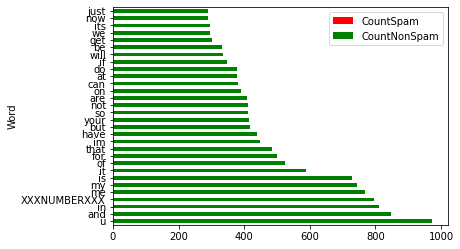

In [83]:
def get_probability_info():
  tokens_nonspam = []
  tokens_spam = []
  df[df["Spam"]==0]["SMS"].map(lambda s: tokens_nonspam.extend(word_tokenize(s)))
  df[df["Spam"]==1]["SMS"].map(lambda s: tokens_spam.extend(word_tokenize(s)))

  text = nltk.Text(tokens_nonspam)
  fdist = dict(FreqDist(text))
  fdist_nonspam = { item: fdist[item] for item in fdist if fdist[item]<1000}

  text = nltk.Text(tokens_spam)
  fdist = dict(FreqDist(text))
  fdist_spam = { item: fdist[item] for item in fdist if fdist[item]<1000}

  words = set(tokens_spam+tokens_nonspam)
  print(f"Всего слов в датасете: {len(words)}")
  words_dist = {}
  for word in words:
    nspam_prob = fdist_nonspam[word] if word in fdist_nonspam else 0
    spam_prob = fdist_spam[word] if word in fdist_spam else 0
    words_dist[word] = (nspam_prob, spam_prob)

  sorted_words_dict = dict(sorted(list(words_dist.items()), key=lambda x: x[1][0]*1000+x[1][1], reverse=True))

  more_to_n_spam_words = [ [word, sorted_words_dict[word][0]] for word in sorted_words_dict if (sorted_words_dict[word][0] > sorted_words_dict[word][1])]
  more_to_spam_words = [ [word, sorted_words_dict[word][1]] for word in sorted_words_dict if (sorted_words_dict[word][0] < sorted_words_dict[word][1])]
  words = [ [word, sorted_words_dict[word][1], sorted_words_dict[word][0]] for word in sorted_words_dict]
  print(f"Список слов, которые выделяются больше в не-спам сообщениях (неспам\спам) \n: {more_to_n_spam_words}")
  print(f"Список слов, которые выделяются больше в спам сообщениях (неспам\спам) \n: {more_to_spam_words}")
  spam_plot = pd.DataFrame(words[:30], columns=["Word", "CountSpam", "CountNonSpam"])
  ax  = spam_plot.plot.barh(x = "Word", y = "CountSpam", color="red")
  spam_plot.plot.barh(x = "Word", y = "CountNonSpam", color="green", ax = ax)
  
get_probability_info()

Также проанализируем тексты смс на распределение длины чтобы определить параметры ембеддинга


The longest SMS has length: 171


<BarContainer object of 67 artists>

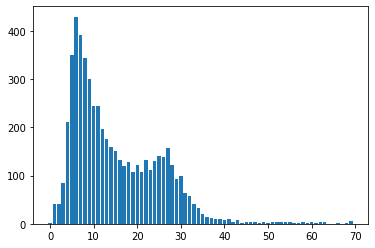

In [19]:
num_words = df["SMS"].apply(lambda x: len(nltk.word_tokenize(x)))
print(f"The longest SMS has length: {num_words.max()}")
lens = [i for i in range(0, num_words.max()) if i in num_words.value_counts() and i < 70]
probs = [(num_words.value_counts()[i]) for i in lens]
plt.bar(lens, probs)

Оставим значение длины маскимального предложения от 50 до 70 слов.

Мы видим различные номера в распределении. Переведем номера в кодовое слово - XXXNUMBERXXX,  потом можно будет выделить как дополнительныю фичу.

In [20]:
#обработчики
def remove_numbers(w):
  if w.isnumeric() or sum([w.count(str(i)) for i in range(0,10)]) > 3:
    return "XXXNUMBERXXX"
  else:
    return remove_punct(w)

def remove_punct(word):
  result = word.translate(str.maketrans('', '', string.punctuation))
  return result

def transform(text):
  result = []
  for w in text.split(' '): 
    result.append(remove_numbers(w))
  return ' '.join(result)

df["SMS"] = df["SMS"].map(lambda s: transform(s))
df.head(n=5)

,Spam,SMS
1,0,go until jurong point crazy available only in ...
2,0,ok lar joking wif u oni
3,1,free entry in XXXNUMBERXXX a wkly comp to win ...
4,0,u dun say so early hor u c already then say
5,0,nah i dont think he goes to usf he lives aroun...


Посмотрим теперь на распределение, и если все ок, начнем обучать. Будем использовать сверточную нейросеть.

Уже конкретнее представление.  Используем свертку одномерную.
Сначала применим токенизацию и переведем слова в числа, а числовые последовательности приведем к единой длине 30 слов. Используя получившиеся данные будем обучать модель: 

In [21]:
 # Global parameters
 num_words = 9558
 max_message_len = 30
 vector_size = 30

In [35]:
print("Применяем перевод текста в числовую последовательность")
x_train, x_test, y_train, y_test = model_selection.train_test_split(df["SMS"], df['Spam'], test_size=0.2, random_state=78)
tokenizer = Tokenizer(num_words= num_words)
tokenizer.fit_on_texts([*x_train, *x_test])
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = pad_sequences(x_train, maxlen=max_message_len)
x_test = pad_sequences(x_test, maxlen=max_message_len)
print(f" Разделили датасет на тренировочную часть: {np.shape(x_train)[0]} сэмплов и тестовую {np.shape(x_test)[0]} в каждом по {np.shape(x_test)[1]} слов")

Применяем перевод текста в числовую последовательность
[[31, 33, 314, 458, 49, 22, 88, 2, 40, 157, 34, 253, 596, 523, 1, 473, 2, 14, 105, 177, 113, 37, 446, 217, 506, 1, 815, 50, 69, 86, 1, 1], [4, 232, 565, 16, 26, 41, 466, 41, 3016, 788, 88, 571, 22, 2, 1282, 1632, 1441, 235, 20, 36, 2277, 14, 292, 45, 3017, 63, 3018], [3462, 743, 7849, 8, 2543, 1041, 8, 2526, 10, 935, 51, 7850, 252, 1198, 223, 34, 1312, 2648, 17, 1, 1005, 1, 86, 461, 17, 1], [3, 107, 178, 6, 105, 141, 22, 125, 69, 5, 154], [908, 147, 35, 14, 25, 127, 7851, 50, 8, 23, 408, 1302, 2, 12, 1152, 283], [131, 181, 1221, 955, 220, 325, 9, 189, 10, 2013, 362, 72, 677, 72, 233, 7852], [345, 430, 16, 57, 31, 16, 94], [57, 82, 26, 2549, 147], [24, 673, 56, 49, 1144, 1815, 3, 501, 230], [179, 5, 1, 172, 140, 27, 5, 140, 642, 1], [487, 7, 312, 30, 59, 7853], [147, 7854, 726, 115, 32, 6, 267, 766, 7855], [100, 42, 2, 2756, 201, 1768, 109, 4, 18, 5, 58, 325, 43, 21, 7, 7856, 1480, 3, 609, 1666, 90], [2993, 45, 6, 75, 3, 234, 4, 76,

Будем использовать сверточную нейросеть с размером окна 3 и скрытым слоем. Выходом будет значение в промежутке [0;1]  

In [87]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=vector_size, input_length=max_message_len))
model.add(Conv1D(100, 3, activation="relu"))
model.add(MaxPooling1D())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [94]:
history = model.fit(x_train, y_train, batch_size=10, epochs=20, validation_split=0.1)

Epoch 1/20
402/402 [==============================] - 3s 7ms/step - loss: 0.0880 - accuracy: 0.9778 - val_loss: 0.3465 - val_accuracy: 0.9358
Epoch 2/20
402/402 [==============================] - 3s 7ms/step - loss: 0.0880 - accuracy: 0.9780 - val_loss: 0.3875 - val_accuracy: 0.9361
Epoch 3/20
402/402 [==============================] - 3s 7ms/step - loss: 0.0881 - accuracy: 0.9781 - val_loss: 0.3666 - val_accuracy: 0.9355
Epoch 4/20
402/402 [==============================] - 3s 7ms/step - loss: 0.0873 - accuracy: 0.9782 - val_loss: 0.3798 - val_accuracy: 0.9367
Epoch 5/20
402/402 [==============================] - 3s 7ms/step - loss: 0.0878 - accuracy: 0.9779 - val_loss: 0.3865 - val_accuracy: 0.9343
Epoch 6/20
402/402 [==============================] - 3s 7ms/step - loss: 0.0874 - accuracy: 0.9782 - val_loss: 0.3974 - val_accuracy: 0.9351
Epoch 7/20
402/402 [==============================] - 3s 7ms/step - loss: 0.0872 - accuracy: 0.9782 - val_loss: 0.4087 - val_accuracy: 0.9345
Epoch 

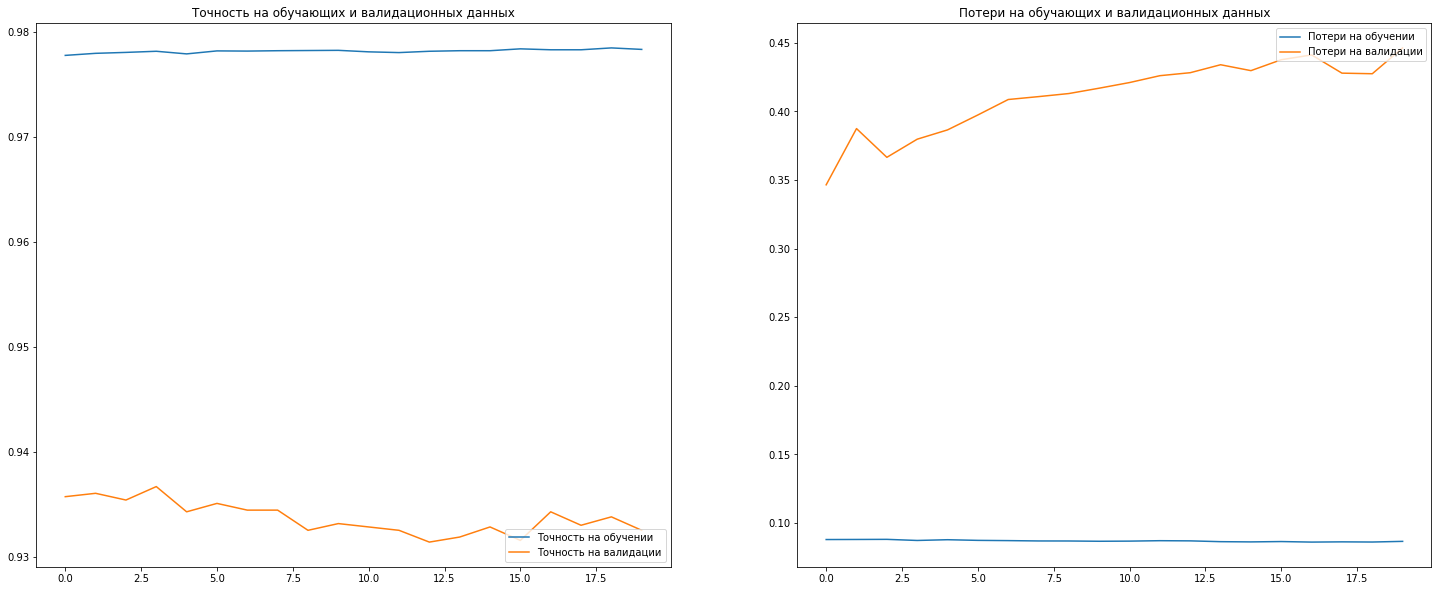

Точность модели по метрике Accuracy: 93.56%
35/35 [==============================] - 0s 4ms/step - loss: 0.4038 - accuracy: 0.9356
Точность по метрике accuracy : 93.55% Значение функции ошибки 0.40383180975914


In [95]:
def plot_loss(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(25,10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Точность на обучении')
  plt.plot(epochs_range, val_acc, label='Точность на валидации')
  plt.legend(loc='lower right')
  plt.title('Точность на обучающих и валидационных данных')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Потери на обучении')
  plt.plot(epochs_range, val_loss, label='Потери на валидации')
  plt.legend(loc='upper right')
  plt.title('Потери на обучающих и валидационных данных')
  plt.show()

plot_loss(history, 20)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность модели по метрике Accuracy: %.2f%%" % (scores[1]*100))
classes = model.predict(x_test, batch_size=128)
info = model.evaluate(x_test, y_test)
print(f"Точность по метрике accuracy : {int(info[1]*10000)/100}% Значение функции ошибки {info[0]}")

Получили метрику 93% Заметно переобучение по большому расстоянию между графиками. Попробуем применить Dropout

In [103]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=vector_size, input_length=max_message_len))
model.add(Conv1D(100, 3, activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPooling1D())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [102]:
history = model.fit(x_train, y_train, batch_size=10, epochs=10, validation_split=0.1)
plot_loss(history, 10)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность модели по метрике Accuracy: %.2f%%" % (scores[1]*100))
classes = model.predict(x_test, batch_size=128)
info = model.evaluate(x_test, y_test)
print(f"Точность по метрике accuracy : {int(info[1]*10000)/100}% Значение функции ошибки {info[0]}")

Epoch 1/10
402/402 [==============================] - 3s 7ms/step - loss: 0.1270 - accuracy: 0.9663 - val_loss: 0.2206 - val_accuracy: 0.9367
Epoch 2/10
402/402 [==============================] - 3s 7ms/step - loss: 0.1223 - accuracy: 0.9674 - val_loss: 0.2322 - val_accuracy: 0.9380
Epoch 3/10
402/402 [==============================] - 3s 7ms/step - loss: 0.1209 - accuracy: 0.9682 - val_loss: 0.2319 - val_accuracy: 0.9374
Epoch 4/10
402/402 [==============================] - 3s 7ms/step - loss: 0.1161 - accuracy: 0.9690 - val_loss: 0.2460 - val_accuracy: 0.9350
Epoch 5/10
402/402 [==============================] - 3s 7ms/step - loss: 0.1139 - accuracy: 0.9703 - val_loss: 0.2477 - val_accuracy: 0.9367
Epoch 6/10
402/402 [==============================] - 3s 7ms/step - loss: 0.1130 - accuracy: 0.9710 - val_loss: 0.2500 - val_accuracy: 0.9366
Epoch 7/10
402/402 [==============================] - 3s 7ms/step - loss: 0.1101 - accuracy: 0.9715 - val_loss: 0.2577 - val_accuracy: 0.9356
Epoch 

KeyboardInterrupt: ignored

получили точность по метрике accuracy - 93%

Также попробуем использовать модель LSTM - Long short-term memory . Длину цепи возьмем 10, опираясь на график распределение длины и добавим дропаут нейронов для защиты от переобучения

In [40]:
model = Sequential()
model.add(Embedding(num_words=9558, output_dim=32, input_length=30))
model.add(LSTM(100, dropout=0.4))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [51]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность модели по метрике Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
126/126 [==============================] - 2s 13ms/step - loss: 2.1732e-05 - accuracy: 1.0000 - val_loss: 0.1151 - val_accuracy: 0.9888
Epoch 2/20
126/126 [==============================] - 2s 12ms/step - loss: 3.2148e-05 - accuracy: 1.0000 - val_loss: 0.1217 - val_accuracy: 0.9888
Epoch 3/20
126/126 [==============================] - 2s 12ms/step - loss: 4.1157e-05 - accuracy: 1.0000 - val_loss: 0.1355 - val_accuracy: 0.9888
Epoch 4/20
126/126 [==============================] - 2s 13ms/step - loss: 2.8616e-05 - accuracy: 1.0000 - val_loss: 0.1365 - val_accuracy: 0.9888
Epoch 5/20
126/126 [==============================] - 2s 13ms/step - loss: 1.2085e-05 - accuracy: 1.0000 - val_loss: 0.1364 - val_accuracy: 0.9888
Epoch 6/20
126/126 [==============================] - 2s 13ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.1010 - val_accuracy: 0.9865
Epoch 7/20
126/126 [==============================] - 2s 13ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.0792 - 

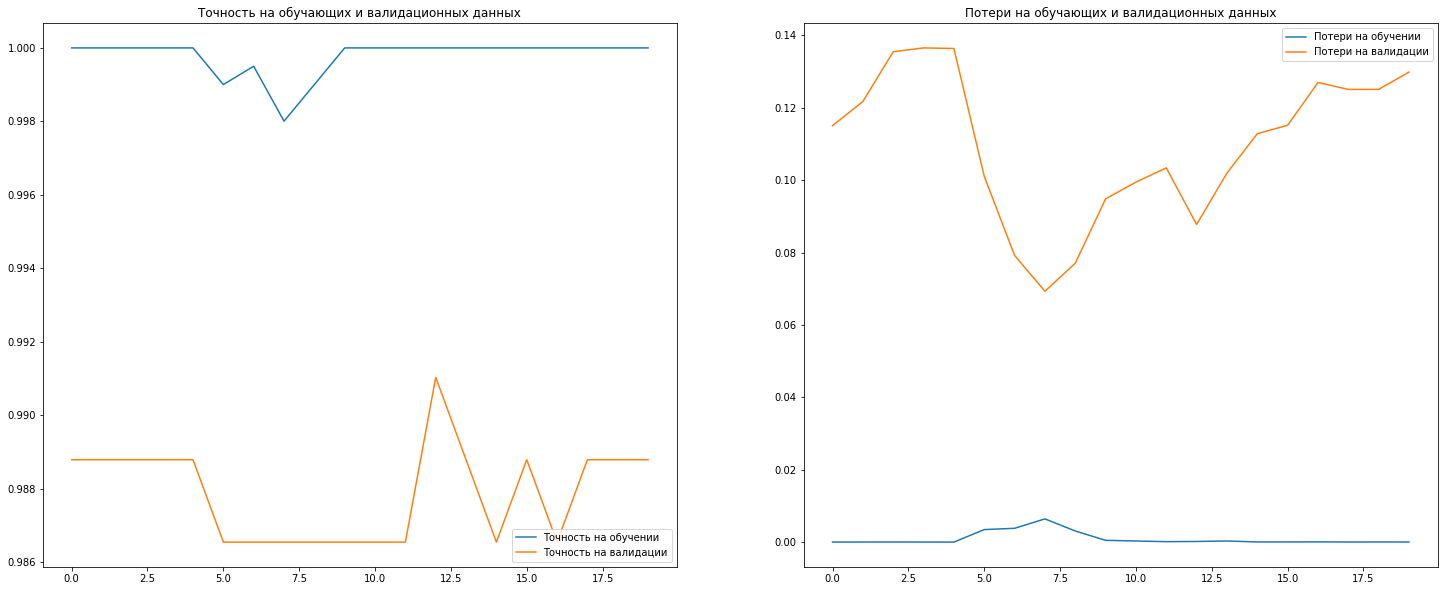

Точность модели по метрике Accuracy: 98.92%
35/35 [==============================] - 0s 5ms/step - loss: 0.0978 - accuracy: 0.9892
Точность по метрике accuracy : 98.92% Значение функции ошибки 0.09783278405666351
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       956
           1       0.99      0.94      0.96       159

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [52]:
plot_loss(history, 20)

scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность модели по метрике Accuracy: %.2f%%" % (scores[1]*100))
classes = model.predict(x_test)
for i in range(len(classes)):
  classes[i] = int(classes[i] > 0.6)
info = model.evaluate(x_test, y_test)
print(f"Точность по метрике accuracy : {int(info[1]*10000)/100}% Значение функции ошибки {info[0]}")
print(classification_report(y_test, classes))

In [53]:
history = model.fit(x_train, y_train, batch_size=32, epochs=6, validation_split=0.1)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность модели по метрике Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/6
126/126 [==============================] - 2s 13ms/step - loss: 3.2303e-05 - accuracy: 1.0000 - val_loss: 0.1374 - val_accuracy: 0.9865
Epoch 2/6
126/126 [==============================] - 2s 13ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0928 - val_accuracy: 0.9888
Epoch 3/6
126/126 [==============================] - 2s 13ms/step - loss: 7.2510e-05 - accuracy: 1.0000 - val_loss: 0.1099 - val_accuracy: 0.9888
Epoch 4/6
126/126 [==============================] - 2s 13ms/step - loss: 1.3175e-04 - accuracy: 1.0000 - val_loss: 0.1074 - val_accuracy: 0.9888
Epoch 5/6
126/126 [==============================] - 2s 13ms/step - loss: 4.4190e-05 - accuracy: 1.0000 - val_loss: 0.1213 - val_accuracy: 0.9888
Epoch 6/6
126/126 [==============================] - 2s 13ms/step - loss: 2.9845e-05 - accuracy: 1.0000 - val_loss: 0.1292 - val_accuracy: 0.9865
Точность модели по метрике Accuracy: 99.01%


С помощью LSTM мы получили точность по метрике accuracy 98.74% после 20 эпох и 99.01% на 5 эпохах.